# **TradeCare: Model Training Notebook**

## Objectives
* Load engineered features dataset
* Filter to recent data (2020-2025) for better model performance
* Train regression model (BR1) to predict price movement
* Train classification model (BR2) to predict trade profitability
* Evaluate both models with appropriate metrics
* Save both models for dashboard deployment

## Inputs
* **Data Source:** `inputs/datasets/processed/bitcoin_features.csv`
* **Features:** 14 technical indicators
* **Targets:** 2 variables (continuous return + binary profitable)
* **Full Dataset:** ~92,000 rows (2014-2025)

## Outputs
* **BR1 Model:** Linear Regression saved as `outputs/models/regression_model.pkl`
* **BR2 Model:** Logistic Regression saved as `outputs/models/classification_model.pkl`
* **Evaluation metrics** for both models
* **Visualizations** showing model performance

## Business Requirements Addressed
* **BR1:** Price Movement Prediction (Regression)
  - Predict: % price change over 4 hours
  - Metrics: RMSE, MAE, R²
  - Use case: Setting stop-loss/take-profit levels

* **BR2:** Trade Profitability Assessment (Classification)
  - Predict: Profitable (1) or Not Profitable (0)
  - Metrics: Accuracy, Confusion Matrix, ROC-AUC
  - Use case: Binary decision support

## CRISP-DM Phase
Modeling → Model Training and Evaluation

---

## Setup

Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Change to project root

In [2]:
current_dir = os.getcwd()
if 'jupyter_notebooks' in current_dir:
    os.chdir(os.path.dirname(current_dir))
    print(f"Changed directory to: {os.getcwd()}")
else:
    print(f"Already in project root: {current_dir}")

Changed directory to: /Users/ilianamarquez/Documents/vscode-projects/trade-care


----

## Load Engineered Features

In [3]:
df = pd.read_csv('inputs/datasets/processed/bitcoin_features.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"✓ Data loaded: {len(df):,} rows")
print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"  Features: {len(df.columns) - 4} (excluding timestamp, price, 2 targets)")
df.head()

✓ Data loaded: 92,127 rows
  Date range: 2014-11-17 09:00:00 to 2025-11-21 19:00:00
  Features: 14 (excluding timestamp, price, 2 targets)


,timestamp,CLOSE_PRICE,return_1h,return_4h,return_12h,return_24h,rsi,ma_10,ma_20,ma_50,dist_from_ma10,dist_from_ma20,volume_change,volume_ratio,volatility_24h,price_range,target_return_simple,target_profitable
0,2014-11-17 09:00:00,409.82,0.020341,0.038229,0.061572,0.057682,81.257533,398.621,390.2830,385.2682,0.028094,0.050059,-0.293987,0.656453,0.010936,0.025328,-0.023059,0
1,2014-11-17 10:00:00,405.72,-0.010004,0.017046,0.052069,0.044647,71.564683,400.649,391.2355,385.4596,0.012657,0.037022,0.498773,0.946520,0.011225,0.013162,-0.019003,0
2,2014-11-17 11:00:00,406.66,0.002317,0.019530,0.054944,0.061997,71.708447,401.900,392.6385,385.6498,0.011844,0.035711,-0.193600,0.790797,0.010700,0.008631,-0.014951,0
3,2014-11-17 12:00:00,404.80,-0.004574,0.007843,0.050228,0.044942,69.582993,402.650,394.0305,385.7478,0.005340,0.027332,0.430754,1.180859,0.010612,0.016774,-0.009313,0
4,2014-11-17 13:00:00,400.37,-0.010944,-0.023059,0.015781,0.038897,63.996992,402.347,395.1950,385.9040,-0.004914,0.013095,0.603766,1.813744,0.010841,0.016085,-0.014861,0


---

## Filter to Recent Data (2020-2025)

**Why Filter to Recent Years:**
* Data cleaning showed 2020+ has 0 time gaps (continuous data)
* Recent market patterns more relevant to current trading
* Faster model training
* Better generalization to future predictions
* 2014-2019 had infrastructure issues (early Bitcoin exchanges)

**Still includes:**
* COVID crash (March 2020)
* 2021 bull run + ATH
* 2022 bear market
* 2024-2025 recovery

**Expected:** ~43,000 - 48,000 rows (5 years of hourly data)

In [4]:
rows_before = len(df)
df = df[df['timestamp'] >= '2020-01-01'].copy()
rows_after = len(df)

print(f"✓ Filtered to recent data (2020-2025)")
print(f"  Before: {rows_before:,} rows")
print(f"  After: {rows_after:,} rows")
print(f"  Dropped: {rows_before - rows_after:,} rows ({(rows_before-rows_after)/rows_before*100:.1f}%)")
print(f"\n  New date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"  Years covered: {(df['timestamp'].max() - df['timestamp'].min()).days / 365:.1f} years")

✓ Filtered to recent data (2020-2025)
  Before: 92,127 rows
  After: 51,643 rows
  Dropped: 40,484 rows (43.9%)

  New date range: 2020-01-01 00:00:00 to 2025-11-21 19:00:00
  Years covered: 5.9 years


---

## Prepare Features and Targets

In [5]:
# Define feature columns
feature_cols = [
    'return_1h', 'return_4h', 'return_12h', 'return_24h',
    'rsi',
    'ma_10', 'ma_20', 'ma_50',
    'dist_from_ma10', 'dist_from_ma20',
    'volume_change', 'volume_ratio',
    'volatility_24h', 'price_range'
]

# Prepare features
X = df[feature_cols].copy()

# Prepare targets
y_regression = df['target_return_simple'].copy()  # BR1: continuous return
y_classification = df['target_profitable'].copy()  # BR2: binary profitable

print(f"✓ Features and targets prepared")
print(f"  Features (X): {X.shape}")
print(f"  Regression target (y_reg): {y_regression.shape}")
print(f"  Classification target (y_clf): {y_classification.shape}")
print(f"\n  Classification balance: {y_classification.value_counts(normalize=True)}")

✓ Features and targets prepared
  Features (X): (51643, 14)
  Regression target (y_reg): (51643,)
  Classification target (y_clf): (51643,)

  Classification balance: target_profitable
1    0.511976
0    0.488024
Name: proportion, dtype: float64


---

## Train/Test Split

**Time-Based Split (Not Random):**
* Time-series data requires chronological split
* Training data = older periods
* Test data = most recent periods
* This simulates real-world: train on past, predict future

**Split Ratio:** 80% train, 20% test
* ~38,000 train rows
* ~10,000 test rows

In [6]:
# Time-based split (shuffle=False preserves chronological order)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, shuffle=False, random_state=42
)

# Same split for classification
_, _, y_train_clf, y_test_clf = train_test_split(
    X, y_classification, test_size=0.2, shuffle=False, random_state=42
)

print(f"✓ Train/Test split complete (time-based)")
print(f"\nTraining set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train_reg: {y_train_reg.shape}")
print(f"  y_train_clf: {y_train_clf.shape}")
print(f"\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test_reg: {y_test_reg.shape}")
print(f"  y_test_clf: {y_test_clf.shape}")

✓ Train/Test split complete (time-based)

Training set:
  X_train: (41314, 14)
  y_train_reg: (41314,)
  y_train_clf: (41314,)

Test set:
  X_test: (10329, 14)
  y_test_reg: (10329,)
  y_test_clf: (10329,)


---

## Feature Scaling

**Why Scale:**
* Features have different units (%, prices, ratios)
* MA values in thousands, returns in decimals
* Scaling ensures all features contribute equally
* Improves model convergence and performance

**StandardScaler:**
* Transforms to mean=0, std=1
* Fit on training data ONLY (prevent data leakage)
* Apply same transformation to test data

In [7]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled (StandardScaler)")
print(f"  Training features scaled: {X_train_scaled.shape}")
print(f"  Test features scaled: {X_test_scaled.shape}")
print(f"\n  Sample scaled values (first feature):")
print(f"    Mean: {X_train_scaled[:, 0].mean():.6f} (should be ~0)")
print(f"    Std: {X_train_scaled[:, 0].std():.6f} (should be ~1)")

✓ Features scaled (StandardScaler)
  Training features scaled: (41314, 14)
  Test features scaled: (10329, 14)

  Sample scaled values (first feature):
    Mean: 0.000000 (should be ~0)
    Std: 1.000000 (should be ~1)


---

## BR1: Train Regression Model (Price Movement Prediction)

### Business Requirement 1: Predict Price Movement

**Goal:** Predict the percentage price change over next 4 hours

**Model:** Linear Regression
* Simple, interpretable
* Fast training
* Good baseline for continuous prediction
* No hyperparameters to tune

**Success Criteria:**
* RMSE < 2% (reasonable for 4h prediction)
* MAE < 1.5%
* R² > 0.3 (shows predictive value over random)

**Use Case:** Traders use predicted return to:
* Set realistic take-profit levels
* Calculate appropriate stop-loss distance
* Estimate position holding time

In [8]:
# Train Linear Regression
print("Training Linear Regression model (BR1)...")
regression_model = LinearRegression()
regression_model.fit(X_train_scaled, y_train_reg)

print(f"✓ Regression model trained")
print(f"  Model: {type(regression_model).__name__}")
print(f"  Features used: {len(feature_cols)}")
print(f"  Training samples: {len(X_train_scaled):,}")

Training Linear Regression model (BR1)...
✓ Regression model trained
  Model: LinearRegression
  Features used: 14
  Training samples: 41,314


### Evaluate Regression Model

In [10]:
# Make predictions
y_train_pred_reg = regression_model.predict(X_train_scaled)
y_test_pred_reg = regression_model.predict(X_test_scaled)

# Calculate metrics - Training set
train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_reg))
train_mae = mean_absolute_error(y_train_reg, y_train_pred_reg)
train_r2 = r2_score(y_train_reg, y_train_pred_reg)

# Calculate metrics - Test set
test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg))
test_mae = mean_absolute_error(y_test_reg, y_test_pred_reg)
test_r2 = r2_score(y_test_reg, y_test_pred_reg)

print("="*60)
print("BR1 REGRESSION MODEL PERFORMANCE")
print("="*60)
print(f"\nTraining Set:")
print(f"  RMSE: {train_rmse:.4f} ({train_rmse*100:.2f}%)")
print(f"  MAE:  {train_mae:.4f} ({train_mae*100:.2f}%)")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f} ({test_rmse*100:.2f}%)")
print(f"  MAE:  {test_mae:.4f} ({test_mae*100:.2f}%)")
print(f"  R²:   {test_r2:.4f}")

# Success criteria check
print(f"\nSuccess Criteria:")
print(f"  RMSE < 2%: {'✓ PASS' if test_rmse < 0.02 else '✗ FAIL'}")
print(f"  MAE < 1.5%: {'✓ PASS' if test_mae < 0.015 else '✗ FAIL'}")
print(f"  R² > 0.3: {'✓ PASS' if test_r2 > 0.3 else '✗ FAIL'}")
print("="*60)

BR1 REGRESSION MODEL PERFORMANCE

Training Set:
  RMSE: 0.0138 (1.38%)
  MAE:  0.0086 (0.86%)
  R²:   0.0106

Test Set:
  RMSE: 0.0098 (0.98%)
  MAE:  0.0066 (0.66%)
  R²:   -0.0368

Success Criteria:
  RMSE < 2%: ✓ PASS
  MAE < 1.5%: ✓ PASS
  R² > 0.3: ✗ FAIL


### Visualize Regression Performance

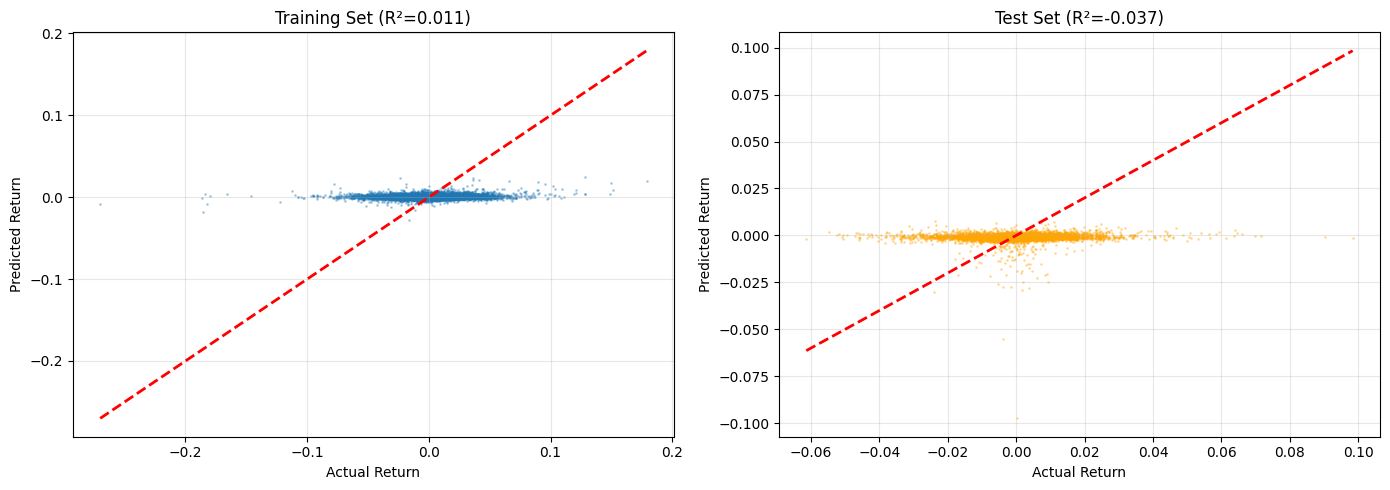

✓ Regression visualization complete
  Red dashed line = perfect prediction
  Points close to line = good predictions


In [11]:
# Predicted vs Actual scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train_reg, y_train_pred_reg, alpha=0.3, s=1)
axes[0].plot([y_train_reg.min(), y_train_reg.max()], 
             [y_train_reg.min(), y_train_reg.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Return')
axes[0].set_ylabel('Predicted Return')
axes[0].set_title(f'Training Set (R²={train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test_reg, y_test_pred_reg, alpha=0.3, s=1, color='orange')
axes[1].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Return')
axes[1].set_ylabel('Predicted Return')
axes[1].set_title(f'Test Set (R²={test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Regression visualization complete")
print("  Red dashed line = perfect prediction")
print("  Points close to line = good predictions")

### Business Requirement 2: Predict Trade Profitability

**Goal:** Predict if a trade will be profitable (binary: yes/no)

**Model:** Logistic Regression
* Simple, interpretable
* Fast training
* Outputs probabilities (0-1 scale)
* No hyperparameters to tune

**Success Criteria:**
* Accuracy > 60% (better than random 50%)
* ROC-AUC > 0.60 (shows predictive value)
* Balanced performance (not biased to one class)

**Use Case:** Traders use probability to:
* Decide whether to enter a trade
* Assess risk level (high/medium/low)
* Compare multiple trade opportunities

In [12]:
# Train Logistic Regression
print("Training Logistic Regression model (BR2)...")
classification_model = LogisticRegression(max_iter=1000, random_state=42)
classification_model.fit(X_train_scaled, y_train_clf)

print(f"✓ Classification model trained")
print(f"  Model: {type(classification_model).__name__}")
print(f"  Features used: {len(feature_cols)}")
print(f"  Training samples: {len(X_train_scaled):,}")

Training Logistic Regression model (BR2)...
✓ Classification model trained
  Model: LogisticRegression
  Features used: 14
  Training samples: 41,314


### Evaluate Classification Model

In [13]:
# Make predictions
y_train_pred_clf = classification_model.predict(X_train_scaled)
y_test_pred_clf = classification_model.predict(X_test_scaled)

# Get probabilities for ROC-AUC
y_train_proba = classification_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = classification_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics - Training set
train_acc = accuracy_score(y_train_clf, y_train_pred_clf)
train_auc = roc_auc_score(y_train_clf, y_train_proba)

# Calculate metrics - Test set
test_acc = accuracy_score(y_test_clf, y_test_pred_clf)
test_auc = roc_auc_score(y_test_clf, y_test_proba)

print("="*60)
print("BR2 CLASSIFICATION MODEL PERFORMANCE")
print("="*60)
print(f"\nTraining Set:")
print(f"  Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  ROC-AUC:  {train_auc:.4f}")

print(f"\nTest Set:")
print(f"  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  ROC-AUC:  {test_auc:.4f}")

# Success criteria check
print(f"\nSuccess Criteria:")
print(f"  Accuracy > 60%: {'✓ PASS' if test_acc > 0.60 else '✗ FAIL'}")
print(f"  ROC-AUC > 0.60: {'✓ PASS' if test_auc > 0.60 else '✗ FAIL'}")

BR2 CLASSIFICATION MODEL PERFORMANCE

Training Set:
  Accuracy: 0.5384 (53.84%)
  ROC-AUC:  0.5506

Test Set:
  Accuracy: 0.5104 (51.04%)
  ROC-AUC:  0.5375

Success Criteria:
  Accuracy > 60%: ✗ FAIL
  ROC-AUC > 0.60: ✗ FAIL


In [14]:
# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print("="*60)
print(classification_report(y_test_clf, y_test_pred_clf, 
                           target_names=['Not Profitable', 'Profitable']))


Detailed Classification Report (Test Set):
                precision    recall  f1-score   support

Not Profitable       0.50      0.79      0.61      5058
    Profitable       0.55      0.24      0.34      5271

      accuracy                           0.51     10329
     macro avg       0.52      0.52      0.47     10329
  weighted avg       0.52      0.51      0.47     10329



### Visualize Classification Performance

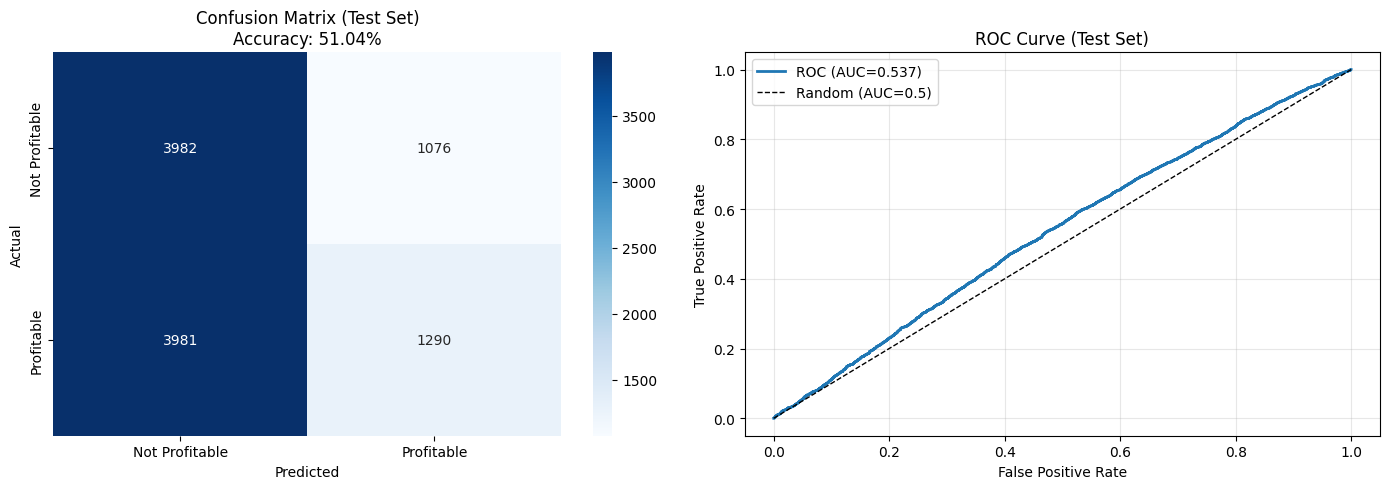

✓ Classification visualization complete


In [16]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_test_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Profitable', 'Profitable'],
            yticklabels=['Not Profitable', 'Profitable'])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title(f'Confusion Matrix (Test Set)\nAccuracy: {test_acc:.2%}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_clf, y_test_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={test_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC=0.5)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (Test Set)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Classification visualization complete")

---

## Save Models

In [17]:
# Create models directory
models_dir = 'outputs/models'
os.makedirs(models_dir, exist_ok=True)

# Save regression model
regression_path = f'{models_dir}/regression_model.pkl'
joblib.dump(regression_model, regression_path)
print(f"✓ Regression model saved: {regression_path}")

# Save classification model
classification_path = f'{models_dir}/classification_model.pkl'
joblib.dump(classification_model, classification_path)
print(f"✓ Classification model saved: {classification_path}")

# Save scaler (needed for dashboard)
scaler_path = f'{models_dir}/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved: {scaler_path}")

# Save feature names (for dashboard)
feature_names_path = f'{models_dir}/feature_names.pkl'
joblib.dump(feature_cols, feature_names_path)
print(f"✓ Feature names saved: {feature_names_path}")

print(f"\n✓ All models saved to: {models_dir}/")

✓ Regression model saved: outputs/models/regression_model.pkl
✓ Classification model saved: outputs/models/classification_model.pkl
✓ Scaler saved: outputs/models/scaler.pkl
✓ Feature names saved: outputs/models/feature_names.pkl

✓ All models saved to: outputs/models/
